### GAN
In this notebook, we will work on a Kaggle project from https://www.kaggle.com/competitions/gan-getting-started, create our network to draw some paintings.

We have two training files, one is the painting from Monet, one is natural scenery photo. Our GAN will learn from those image.

We will use CycleGAN according to the artical 'CycleGAN with Better Cycles', from https://www.tongzhouwang.info/better_cycles/report.pdf

In [1]:
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

import torchvision.transforms as transforms
from torchvision.utils import make_grid

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import itertools

### Data Analysis
First, let's look at our training image.

In [2]:
ROOT = "kaggle/input/gan-getting-started"
TRAIN_PATH = '/monet_jpg'
TEST_PATH = '/photo_jpg'
IMAGE_SIZE = 256


n_monet = len(glob.glob(os.path.join(ROOT+'/monet_jpg')+'/*.*'))
n_photo = len(glob.glob(os.path.join(ROOT+'/photo_jpg')+'/*.*'))
print(f'Monet image: {n_monet}')
print(f'photo image: {n_photo}')

Monet image: 300
photo image: 7038


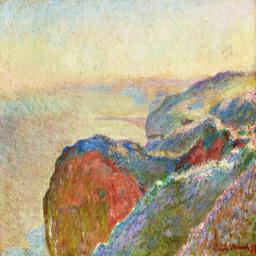

In [3]:
# monet
Image.open(ROOT+"/monet_jpg/000c1e3bff.jpg")  

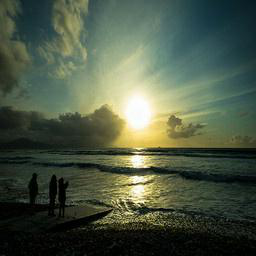

In [4]:
# photo
Image.open(ROOT+"/photo_jpg/000ded5c41.jpg")  

### Data Loader
Our goal is lreaning the pattern of the painting, so we only resize each image. We also write loader function for data loading.

In [20]:
basic_transforms = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.1), Image.BICUBIC),
    transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

no_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class ImageDataset(Dataset):
    def __init__(self, transform, mode='train', unaligned=True):
        self.mode = mode
        self.unaligned = unaligned
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(ROOT+'/monet_jpg')+'/*.*'))
        '''My GPU only have 8GB, if using all the image, it will run out of memory. '''
        
        self.files_B = sorted(glob.glob(os.path.join(ROOT+'/photo_jpg')+'/*.*'))[:2000]

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[torch.randint(0, len(self.files_B)-1, (1,1))])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        if self.mode == "train":
            return min(len(self.files_A), len(self.files_B))
        else:
            return max(len(self.files_A), len(self.files_B))

### Generator

In [6]:
# Basic residual block, we will use it later for buliding our generator and discriminator
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)
    
    
class Generator(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(Generator, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.BatchNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.BatchNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.BatchNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)
    

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        channels, height, width = input_shape
        
        # Calculate output shape of image discriminator
        self.output_shape = (1, height//2**4, width//2**4)
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            #Returns downsampling layers of each discriminator block
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128,256),
            *discriminator_block(256,512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
    def forward(self, img):
        return self.model(img)

### Loss Function

In [8]:
GAN_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

### Model, Data Setting

In [21]:
BATCH_SIZE = 4
INPUT_SHAPE = (3, 256, 256) # (3,256,256)
n_residual_blocks = 4  # default structure from the article

train_data_loader = DataLoader(
    ImageDataset(transform=basic_transforms, unaligned=True),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_data_loader = DataLoader(
    ImageDataset(transform=no_transforms, mode='test', unaligned=False),
    batch_size=1,
    shuffle=False
)

G_AB = Generator(INPUT_SHAPE, n_residual_blocks)
G_BA = Generator(INPUT_SHAPE, n_residual_blocks)
D_A = Discriminator(INPUT_SHAPE)
D_B = Discriminator(INPUT_SHAPE)

cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    
    GAN_loss.cuda()
    cycle_loss.cuda()
    identity_loss.cuda()

### Hyperparameters Setting

In [24]:
lr = 0.0005
EPOCH = 1
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr)
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr)

scheduler_G = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_G,T_max=EPOCH+3)
scheduler_D_A = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_D_A,T_max=EPOCH+3)
scheduler_D_B = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_D_B,T_max=EPOCH+3)

### Training

In [25]:
for epoch in range(EPOCH):
    for i, batch in enumerate(tqdm(train_data_loader)):
        
        # Set model input
        real_A = batch['A'].type(Tensor)
        real_B = batch['B'].type(Tensor)
        
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) 
        fake = Tensor(np.zeros((real_B.size(0), *D_B.output_shape))) 
        
        # -----------------
        '''Train Generators'''
        # -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # A -Gab()-> B -Gba()-> A'
        # Identity Loss: feed G with its output, it should not change
        loss_id_A = identity_loss(G_BA(real_A), real_A) 
        loss_id_B = identity_loss(G_AB(real_B), real_B) 
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss: discriminate the GAN image
        fake_B = G_AB(real_A) 
        loss_GAN_AB = GAN_loss(D_B(fake_B), valid) 
        fake_A = G_BA(real_B)
        loss_GAN_BA = GAN_loss(D_A(fake_A), valid) 
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss: training the G()
        recov_A = G_BA(fake_B) # recov_A is A' that create from B
        loss_cycle_A = cycle_loss(recov_A, real_A) 
        recov_B = G_AB(fake_A)
        loss_cycle_B = cycle_loss(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        
        # Total Loss
        # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) 
        
        loss_G.backward()
        optimizer_G.step()
        
        # -----------------
        '''Train Discriminator A'''
        # -----------------
        optimizer_D_A.zero_grad()
    
        loss_real = GAN_loss(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = GAN_loss(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_A = (loss_real + loss_fake)/2
        loss_D_A.backward()
        optimizer_D_A.step()
        
        # -----------------
        '''Train Discriminator B'''
        # -----------------
        optimizer_D_B.zero_grad()
    
        loss_real = GAN_loss(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = GAN_loss(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_B = (loss_real + loss_fake)/2
        loss_D_B.backward()
        optimizer_D_B.step()
        
        # Total discriminator Loss
        loss_D = (loss_D_A + loss_D_B)/2
    
    # -----------------
    '''Show Progress'''
    # -----------------
    print('[Epoch %d/%d]  [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
            %(epoch+1,EPOCH,       
                loss_D.item(),       
                loss_G.item(),       
                loss_GAN.item(),     
                loss_cycle.item(),   
                loss_identity.item(),
              ))
    
    scheduler_G.step()
    scheduler_D_A.step()
    scheduler_D_B.step()

  0%|          | 0/75 [00:00<?, ?it/s]

NameError: name 'n_epochs' is not defined

In [27]:
print('[Epoch %d/%d]  [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
            %(epoch+1,EPOCH,       
                loss_D.item(),       
                loss_G.item(),       
                loss_GAN.item(),     
                loss_cycle.item(),   
                loss_identity.item(),
              ))

[Epoch 1/1]  [D loss : 0.225223] [G loss : 3.701349 - (adv : 0.296683, cycle : 0.231427, identity : 0.218080)]


In [ ]:
os.makedirs("kaggle/working/images", exist_ok=True)
G_BA.eval()
with torch.no_grad():
    for i, img in enumerate(val_data_loader):
        img = Variable(img["B"]).cuda()
        img = G_BA(img)
        save_image(img, ("/kaggle/working/images/" + str(i) + ".jpg"), normalize=True)

In [ ]:
fig = plt.figure(figsize=(20, 20))
for i in range(9):
    img = Image.open("kaggle/working/images/" + str(i) + ".jpg")
    fig.add_subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")